In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from datetime import date

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

#import wandb
#wandb.login()

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


['config.ini']

In [2]:
dataroot = "data/portraits/"

IMAGE_SIZE = config['default'].getint('image_size')
CHANNELS = config['default'].getint('channels')
BATCH_SIZE = config['default'].getint('batch_size')
SEED = config['default'].getint('seed')

EPOCHS = config['training'].getint('epochs')
START_LR = config['training'].getfloat('start_lr')
MAX_LR = config['training'].getfloat('max_lr')
STEPS_PER_EPOCH = config['training'].getint('steps_per_epoch')
ANNEAL_STRATEGY = config['training']['strategy']

GEN_FEATURE_MAPS = config['generator'].getint('feature_maps')
Z_LATENT = config['generator'].getint('z_latent')
DIS_FEATURE_MAPS = config['discriminator'].getint('feature_maps')

N_GPUS = 1

"""
wandb.config.update({'epochs': EPOCHS, 
                     'image_size': IMAGE_SIZE, 
                     'batch_size': BATCH_SIZE,
                     'start_lr': START_LR,
                     'max_lr': MAX_LR, 
                     'strategy': ANNEAL_STRATEGY})
"""

"\nwandb.config.update({'epochs': EPOCHS, \n                     'image_size': IMAGE_SIZE, \n                     'batch_size': BATCH_SIZE,\n                     'start_lr': START_LR,\n                     'max_lr': MAX_LR, \n                     'strategy': ANNEAL_STRATEGY})\n"

In [11]:
data = tf.keras.preprocessing.image_dataset_from_directory(dataroot, label_mode=None, image_size=(64, 64), batch_size=BATCH_SIZE)
data = data.map(lambda x: x / 255.0)

Found 4117 files belonging to 1 classes.


In [14]:
#Building a Generator
generator = keras.Sequential()
generator.add(layers.Dense(4 * 4 * 256, activation="relu", input_dim=Z_LATENT))
generator.add(layers.Reshape((4,4,256)))
generator.add(layers.UpSampling2D())

generator.add(layers.Conv2D(256, kernel_size=3, padding="same"))
generator.add(layers.BatchNormalization(momentum=0.8))
generator.add(layers.Activation("relu"))
generator.add(layers.UpSampling2D())

generator.add(layers.Conv2D(256, kernel_size=3, padding="same"))
generator.add(layers.BatchNormalization(momentum=0.8))
generator.add(layers.Activation("relu"))
generator.add(layers.UpSampling2D())

generator.add(layers.Conv2D(256, kernel_size=3, padding="same"))#
generator.add(layers.BatchNormalization(momentum=0.8))
generator.add(layers.Activation("relu"))
generator.add(layers.UpSampling2D())

generator.add(layers.Conv2D(128, kernel_size=3, padding="same"))
generator.add(layers.BatchNormalization(momentum=0.8))
generator.add(layers.Activation("relu"))

generator.add(layers.Conv2D(3, kernel_size=3, padding="same"))
generator.add(layers.Activation("tanh"))

generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4096)              413696    
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_8 (UpSampling  (None, 8, 8, 256)        0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization_12 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 8, 8, 256)        

(-0.5, 63.5, 63.5, -0.5)

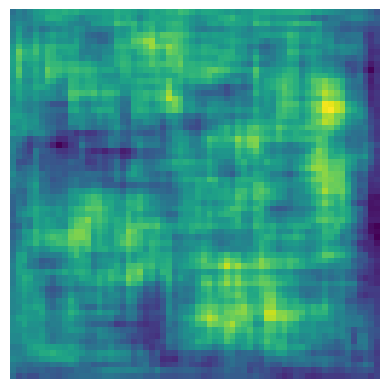

In [19]:
seed = tf.random.normal([1, Z_LATENT])
Generated_Portrait = generator(seed, training=False)
#Plotting the image output of generator without training 
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

In [20]:
discriminator = keras.Sequential()

discriminator.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dropout(0.25))

discriminator.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(layers.BatchNormalization(momentum=0.8))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dropout(0.25))

discriminator.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(layers.BatchNormalization(momentum=0.8))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dropout(0.25))

discriminator.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(layers.BatchNormalization(momentum=0.8))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dropout(0.25))

discriminator.add(layers.Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(layers.BatchNormalization(momentum=0.8))
discriminator.add(layers.LeakyReLU(alpha=0.2))
discriminator.add(layers.Dropout(0.25))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 17, 17, 64)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_20 (Bat  (None, 17, 17, 64)       256       
 chNormalization)                                     

In [21]:
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.5010617]], shape=(1, 1), dtype=float32)


In [22]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [24]:
discriminator_opt = tf.keras.optimizers.Adam()
generator_opt = tf.keras.optimizers.Adam()
#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=Z_LATENT)

#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=EPOCHS)

Epoch 1/5


2023-04-19 14:40:55.174779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 71s 510ms/step - d_loss: 152835.0781 - g_loss: 3930080.2500
Epoch 2/5
129/129 [==============================] - 65s 494ms/step - d_loss: 1329.8315 - g_loss: 88252.4453
Epoch 3/5
129/129 [==============================] - 68s 516ms/step - d_loss: -980.4760 - g_loss: 108174.1250
Epoch 4/5
129/129 [==============================] - 63s 479ms/step - d_loss: -27147.0625 - g_loss: 2442842.2500
Epoch 5/5
129/129 [==============================] - 63s 476ms/step - d_loss: 399464288.0000 - g_loss: 19080513536.0000


Text(0.5, 1.0, 'Learning Curve')

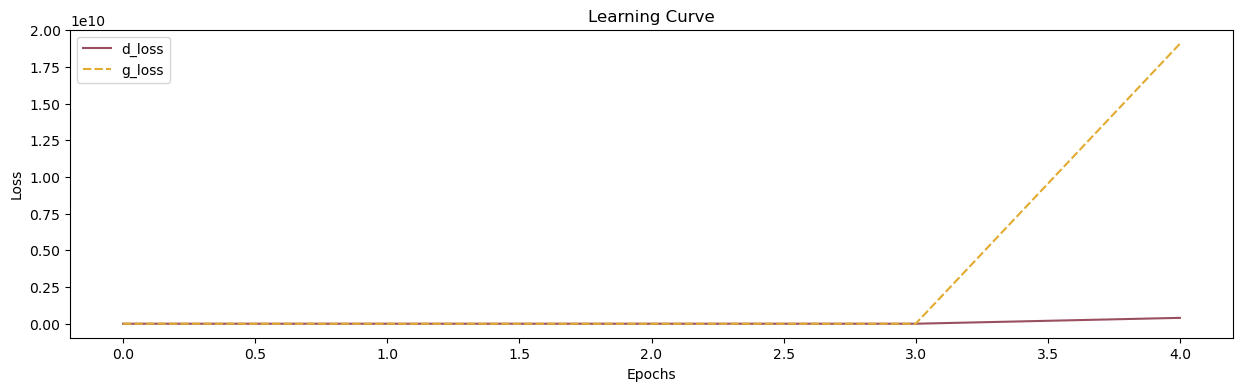

In [25]:
import seaborn as sns

pal=["#994F5F","#E2AB30"]
#Plotting the learning curve
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
ax = sns.lineplot(data=history_df, palette= pal)
ax.set(xlabel ="Epochs")
ax.set(ylabel ="Loss")
ax.set_title("Learning Curve")

In [26]:
num_img=18

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, Z_LATENT])
    generated_image = generator(seed)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("Potraits{:02d}.png".format(i)) 
    return 

#Generating images
Images = Potrait_Generator()